#2-5

In [1]:
# install library for slice musics
!pip install pydub
from pydub import AudioSegment
import math
import os
import csv
import librosa
import numpy as np
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Preprocessing**

In [16]:
dataset_path = "/content/drive//MyDrive/sample_ML/"
result_path = "/content/drive/MyDrive/sample_ML/sample"

In [17]:
#header csv file
list1 = ['filename', 'chroma_stft', 'rms', 'spectral_centroid', 'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate']
list2 = [f'mfcc{i}' for i in range(1,21)]
header = list1 + list2 + ['label']
df = pd.DataFrame(columns=header)
#function feature extraction
def feature_extraction(path,label):
  for music_name in os.listdir(path):
      #read file
      file_path = path +'/'+ music_name
      print(file_path)

      #read song
      wave, samp_rate = librosa.load(file_path, mono=True)

      #get feature
      spectral_centroid = librosa.feature.spectral_centroid(y=wave, sr=samp_rate)       
      mfcc = librosa.feature.mfcc(y=wave, sr=samp_rate)
      rms = librosa.feature.rms(y=wave)
      spectral_bandwidth = librosa.feature.spectral_bandwidth(y=wave, sr=samp_rate)
      spectral_rolloff = librosa.feature.spectral_rolloff(y=wave, sr=samp_rate)
      zero_crossing_rate = librosa.feature.zero_crossing_rate(y=wave)
      chroma_stft = librosa.feature.chroma_stft(y=wave, sr=samp_rate)

      #get mean of each feature
      list1 = [music_name,np.mean(chroma_stft),np.mean(rms),np.mean(spectral_centroid),np.mean(spectral_bandwidth),np.mean(spectral_rolloff),np.mean(zero_crossing_rate)]
      list2 = [np.mean(mf) for mf in mfcc]
      mean_feature = list1 + list2 + [label]

      df.loc[df.shape[0]] = mean_feature

In [20]:
for directory_name in os.listdir(dataset_path):
  genre_path = dataset_path + directory_name
  number = 0
  for music_name in os.listdir(genre_path):
      if music_name.split('.')[-1] == "mp3":
        music = AudioSegment.from_mp3(os.path.join(genre_path, music_name))
        path = result_path + directory_name
        start=0
        for end in range(45000,len(music),45000):
          name = "_{}.wav".format(number)
          sec = music[start:end]
          sec.export(path + name, format = "wav")
          number +=1
          start = end
 # feature_extraction("/content/result",directory_name)
 # !rm -rf 'result'

In [13]:
!rm -rf 'result'

In [ ]:
#download features file
df.to_csv('features.csv')

#2-6

In [ ]:
!pip install -q scikit-plot
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import learning_curve
import scikitplot as skplt

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/ML/project/features.csv")
df = df.iloc[:,1:29]
df.head()

,filename,chroma_stft,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0,Bandari_1443.wav,0.385338,0.321449,2742.200969,2730.893005,5997.863732,0.136198,20.062084,78.168983,6.033637,23.952497,8.421409,2.025541,-10.654094,6.750089,-9.548324,3.632612,-3.931255,1.080126,0.501369,3.819694,0.632546,4.022167,-8.230503,2.809771,-2.186619,-0.454575,Bandari
1,Bandari_561.wav,0.360864,0.131163,2761.785385,2591.650156,5697.648880,0.147271,-57.712135,75.162651,-11.747077,23.997705,0.522057,9.510628,0.444517,0.156660,-1.297874,1.958092,-4.801153,3.877494,-2.817235,5.846106,-4.051405,2.599230,-6.418496,-2.665313,-3.070375,5.995946,Bandari
2,Bandari_510.wav,0.256995,0.206920,2716.665536,2954.971978,6309.039628,0.097525,-94.775764,74.480568,25.467127,8.992518,6.258727,11.999546,10.816494,13.319936,-1.114603,2.158527,-2.738725,4.824709,4.432208,4.557103,-5.857443,-1.156024,-6.441401,3.425208,-2.205493,0.934923,Bandari
3,Bandari_716.wav,0.400040,0.235502,2843.018475,2931.418769,6558.665896,0.107354,-24.535557,70.013870,17.683250,25.532721,4.828485,8.666070,4.614975,8.587525,-3.646995,9.565742,-1.217263,4.292939,0.169256,5.688190,-2.197018,3.345847,-5.779459,-0.948961,-7.175944,-3.015051,Bandari
4,Bandari_698.wav,0.386944,0.296843,2419.476985,2708.287612,5658.276896,0.086569,-35.459721,79.925049,9.250431,13.760175,-3.395043,10.120485,-3.976239,2.935897,-3.835881,3.458317,-0.394308,7.320758,-0.021413,7.607381,0.188875,4.050068,-2.461287,2.061041,-3.238700,1.078692,Bandari


In [ ]:
print('Bandari:',len(df[df['label']=='Bandari']))
print('Gilaki:',len(df[df['label']=='Gilaki']))
print('Kordi:',len(df[df['label']=='Kordi']))
print('Lori:',len(df[df['label']=='Lori']))
print('Torki:',len(df[df['label']=='Torki']))

Bandari: 1707
Gilaki: 1507
Kordi: 1688
Lori: 1708
Torki: 1411


**Balanced Data**

In [ ]:
max_size = 1708
dataset = [df]
for class_index, group in df.groupby('label'):
    dataset.append(group.sample(max_size-len(group), replace=True , random_state=1))
balanced_df = pd.concat(dataset)
balanced_df.reset_index(drop=True)
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [ ]:
print('Bandari:',len(balanced_df[balanced_df['label']=='Bandari']))
print('Gilaki:',len(balanced_df[balanced_df['label']=='Gilaki']))
print('Kordi:',len(balanced_df[balanced_df['label']=='Kordi']))
print('Lori:',len(balanced_df[balanced_df['label']=='Lori']))
print('Torki:',len(balanced_df[balanced_df['label']=='Torki']))

Bandari: 1708
Gilaki: 1708
Kordi: 1708
Lori: 1708
Torki: 1708


In [ ]:
features = balanced_df.iloc[:,1:27].values

label = balanced_df['label']
label = label.map({'Bandari': 0,'Gilaki':1, 'Kordi':2, 'Lori':3, 'Torki':4})
features.shape

(8540, 26)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.25, random_state=7644)

In [ ]:
def classification_model(model,title):
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print('Train accuracy: ',round(model.score(X_train,y_train),3),'\n')
  print(classification_report(y_test,y_pred))
  skplt.metrics.plot_confusion_matrix(y_test,y_pred,title=title,figsize=(12,6))

**Unscaled Data Classification**

Train accuracy:  0.642 

              precision    recall  f1-score   support

           0       0.46      0.58      0.52       442
           1       0.48      0.53      0.50       418
           2       0.41      0.36      0.38       450
           3       0.45      0.42      0.44       414
           4       0.42      0.36      0.38       411

    accuracy                           0.45      2135
   macro avg       0.45      0.45      0.44      2135
weighted avg       0.45      0.45      0.44      2135



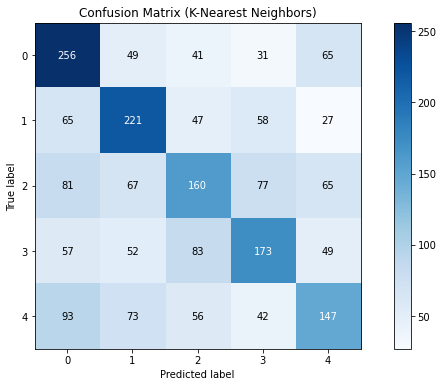

In [ ]:
knn = KNeighborsClassifier()
classification_model(knn,"Confusion Matrix (K-Nearest Neighbors)")

Train accuracy:  0.328 

              precision    recall  f1-score   support

           0       0.43      0.56      0.49       442
           1       0.44      0.02      0.03       418
           2       0.40      0.01      0.02       450
           3       0.28      0.70      0.40       414
           4       0.28      0.35      0.31       411

    accuracy                           0.32      2135
   macro avg       0.37      0.33      0.25      2135
weighted avg       0.37      0.32      0.25      2135



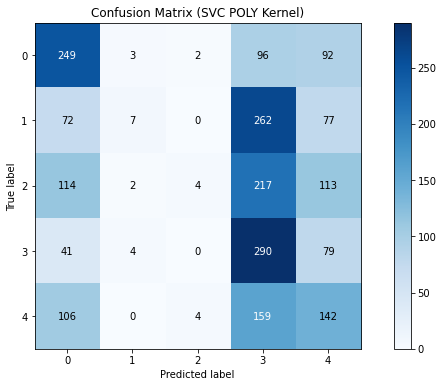

In [ ]:
SVC_poly = SVC(kernel='poly')
classification_model(SVC_poly,"Confusion Matrix (SVC POLY Kernel)")

Train accuracy:  0.341 

              precision    recall  f1-score   support

           0       0.42      0.56      0.48       442
           1       0.43      0.21      0.28       418
           2       0.00      0.00      0.00       450
           3       0.31      0.56      0.40       414
           4       0.28      0.41      0.33       411

    accuracy                           0.34      2135
   macro avg       0.29      0.35      0.30      2135
weighted avg       0.29      0.34      0.30      2135



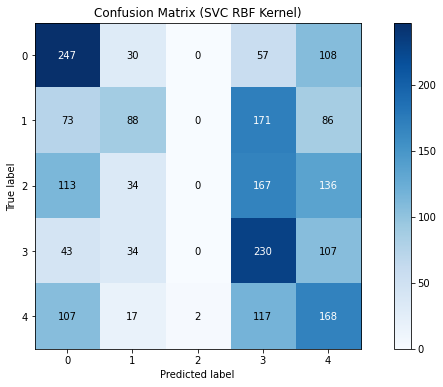

In [ ]:
SVC_rbf = SVC(kernel='rbf')
classification_model(SVC_rbf,"Confusion Matrix (SVC RBF Kernel)")

Train accuracy:  0.372 

              precision    recall  f1-score   support

           0       0.46      0.30      0.37       442
           1       0.46      0.42      0.43       418
           2       0.37      0.06      0.10       450
           3       0.43      0.43      0.43       414
           4       0.26      0.63      0.37       411

    accuracy                           0.36      2135
   macro avg       0.40      0.37      0.34      2135
weighted avg       0.40      0.36      0.34      2135



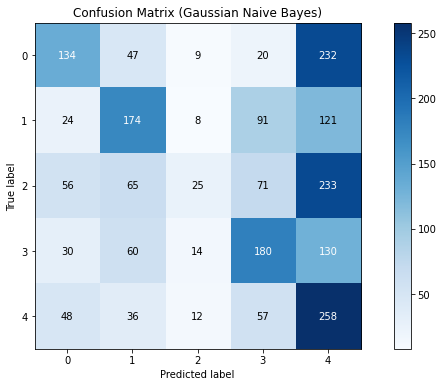

In [ ]:
GNB = GaussianNB()
classification_model(GNB,"Confusion Matrix (Gaussian Naive Bayes)")

Train accuracy:  0.304 

              precision    recall  f1-score   support

           0       0.32      0.78      0.46       442
           1       0.30      0.68      0.42       418
           2       0.30      0.06      0.09       450
           3       0.38      0.05      0.09       414
           4       0.00      0.00      0.00       411

    accuracy                           0.32      2135
   macro avg       0.26      0.31      0.21      2135
weighted avg       0.27      0.32      0.21      2135



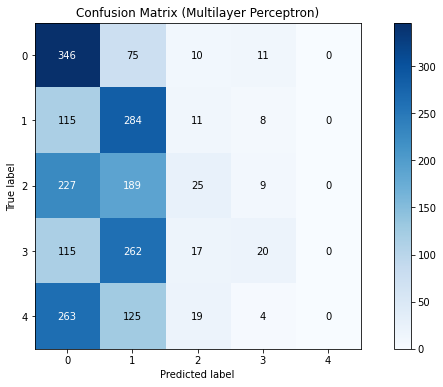

In [ ]:
MLP = MLPClassifier(
    activation='logistic', 
    solver='adam', 
    alpha=0.001, 
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    epsilon=1e-08, 
    hidden_layer_sizes=(300,), 
    learning_rate='adaptive',
    max_iter=1000,
    random_state=69
)
classification_model(MLP,"Confusion Matrix (Multilayer Perceptron)")

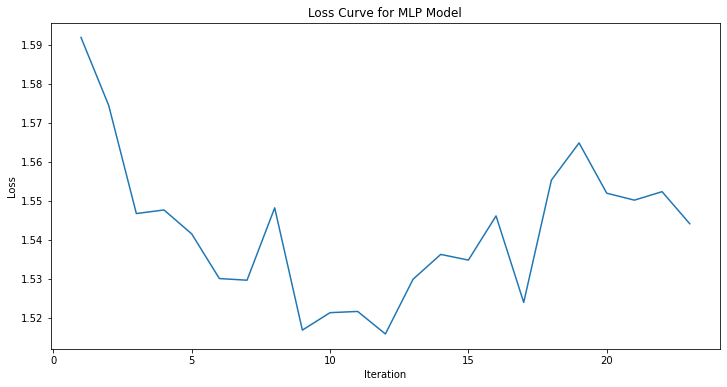

In [ ]:
plt.figure(figsize=(12,6))
plt.plot([num for num in range(1,MLP.n_iter_ +1)], MLP.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

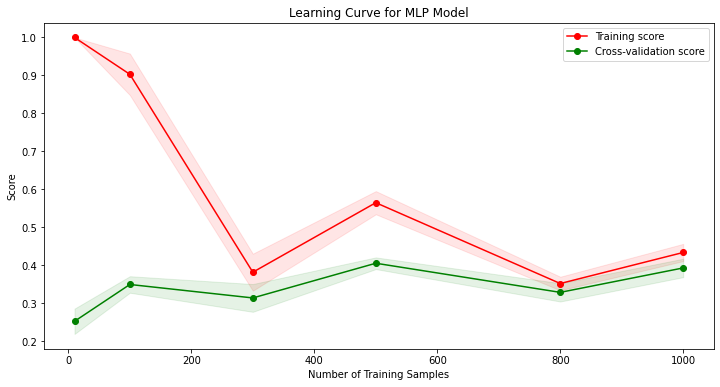

In [ ]:
# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    MLP, 
    X=X_train, 
    y=y_train, 
    cv=10, 
    shuffle=True,
    random_state=69,
    n_jobs=4,  
    train_sizes=[10,100,300,500,800, 1000]
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12,6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()

**Scaled Data Classification**

In [ ]:
transformer = StandardScaler().fit(features)
scaler_feature = transformer.transform(features)

X_train, X_test, y_train, y_test = train_test_split(scaler_feature, label, test_size=0.25, random_state=7644)

Train accuracy:  0.9 

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       442
           1       0.80      0.89      0.85       418
           2       0.83      0.79      0.81       450
           3       0.86      0.79      0.82       414
           4       0.78      0.73      0.75       411

    accuracy                           0.81      2135
   macro avg       0.81      0.81      0.81      2135
weighted avg       0.81      0.81      0.81      2135



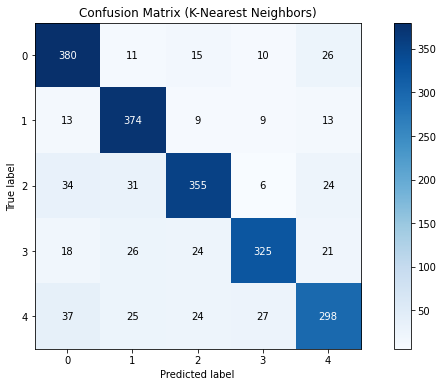

In [ ]:
knn = KNeighborsClassifier()
classification_model(knn,"Confusion Matrix (K-Nearest Neighbors)")

Train accuracy:  0.696 

              precision    recall  f1-score   support

           0       0.78      0.66      0.71       442
           1       0.91      0.61      0.73       418
           2       0.76      0.51      0.61       450
           3       0.76      0.58      0.66       414
           4       0.41      0.86      0.55       411

    accuracy                           0.64      2135
   macro avg       0.72      0.64      0.65      2135
weighted avg       0.73      0.64      0.65      2135



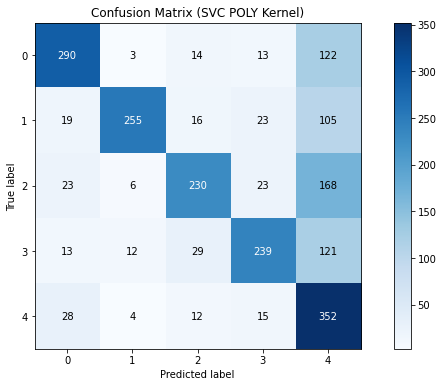

In [ ]:
SVC_poly = SVC(kernel='poly')
classification_model(SVC_poly,"Confusion Matrix (SVC POLY Kernel)")

Train accuracy:  0.765 

              precision    recall  f1-score   support

           0       0.75      0.81      0.78       442
           1       0.82      0.72      0.77       418
           2       0.75      0.70      0.72       450
           3       0.73      0.68      0.70       414
           4       0.58      0.68      0.62       411

    accuracy                           0.72      2135
   macro avg       0.73      0.72      0.72      2135
weighted avg       0.73      0.72      0.72      2135



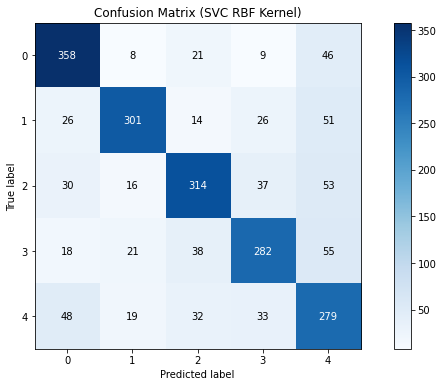

In [ ]:
SVC_rbf = SVC(kernel='rbf')
classification_model(SVC_rbf,"Confusion Matrix (SVC RBF Kernel)")

Train accuracy:  0.375 

              precision    recall  f1-score   support

           0       0.47      0.33      0.39       442
           1       0.46      0.41      0.43       418
           2       0.41      0.06      0.10       450
           3       0.43      0.44      0.43       414
           4       0.26      0.61      0.37       411

    accuracy                           0.36      2135
   macro avg       0.41      0.37      0.34      2135
weighted avg       0.41      0.36      0.34      2135



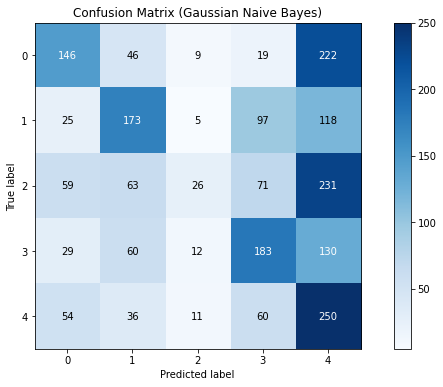

In [ ]:
GNB = GaussianNB()
classification_model(GNB,"Confusion Matrix (Gaussian Naive Bayes)")

Train accuracy:  0.967 

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       442
           1       0.81      0.85      0.83       418
           2       0.82      0.80      0.81       450
           3       0.80      0.80      0.80       414
           4       0.79      0.78      0.79       411

    accuracy                           0.81      2135
   macro avg       0.81      0.81      0.81      2135
weighted avg       0.81      0.81      0.81      2135



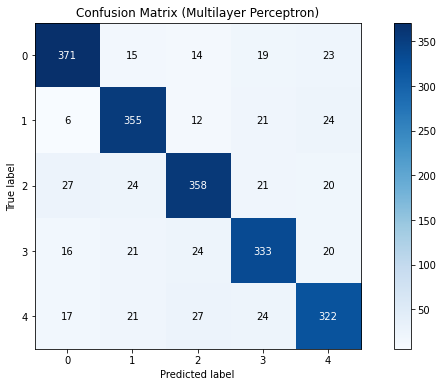

In [ ]:
MLP = MLPClassifier(
    activation='logistic', 
    solver='adam', 
    alpha=0.001, 
    beta_1=0.9,
    beta_2=0.999,
    batch_size=256, 
    epsilon=1e-08, 
    hidden_layer_sizes=(300,), 
    learning_rate='adaptive',
    max_iter=1000,
    random_state=69
)
classification_model(MLP,"Confusion Matrix (Multilayer Perceptron)")

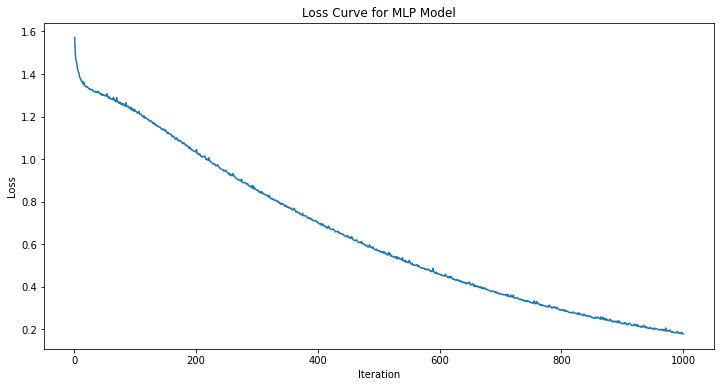

In [ ]:
plt.figure(figsize=(12,6))
plt.plot([num for num in range(1,MLP.n_iter_ +1)], MLP.loss_curve_)
plt.title('Loss Curve for MLP Model')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.show()

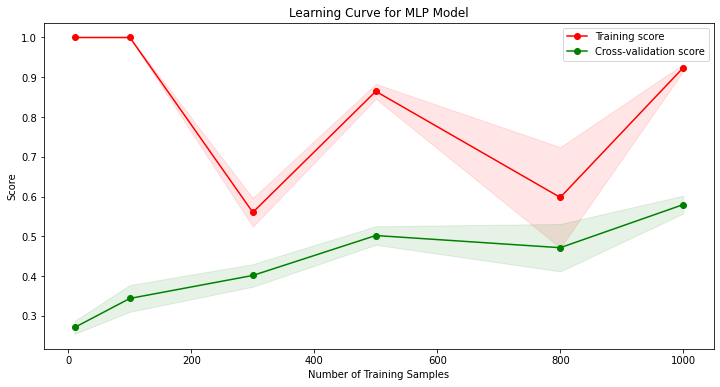

In [ ]:
# Build learning curve
train_sizes, train_scores, test_scores = learning_curve(
    MLP, 
    X=X_train, 
    y=y_train, 
    cv=10, 
    shuffle=True,
    random_state=69,
    n_jobs=4,  
    train_sizes=[10,100,300,500,800, 1000]
)
# Get errors for learning curve
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12,6))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.title('Learning Curve for MLP Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('Score')
plt.legend(loc="best")
plt.show()